In [1]:
import numpy as np
import rebound
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict

In [2]:
def wrapRad(theta, k):
    return (theta + k*np.pi) % (2*k*np.pi) - k*np.pi

$$ param: \qquad
r = \frac{j_2}{j_1},\qquad
\epsilon_1 = \mu_1 |C_1| e^{k_1},\qquad
\epsilon_2 = \mu_2 |C_2| e^{k_2}, \qquad
\nu = \frac{1}{\sqrt{3}}\frac{n_{r2}-n_{r1}}{n_{r1}} = \frac{1}{\sqrt{3}}\left(\frac{j_1(j_2+k_2)}{j_2(j_1-k_1)}\frac{n_2}{n_1}-1\right)$$

In [3]:
def param2OE(param, userDefined):
    r, nu, epsilon1, epsilon2 = param
    ecc, P1, j1, k1, k2 = userDefined
    
    j2 = r*j1
    
    #calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get mu1 and mu2
    mu1 = epsilon1 / (abs(Cval1) * ecc**k1)
    mu2 = epsilon2 / (abs(Cval2) * ecc**k2)
    
    # get P2
    P2 = P1 * j1*(j2+k2) / (j2*(j1-k1)*(np.sqrt(3)*nu + 1))
    
    if Cval1 > 0:
        sign1 = 0
    else:
        sign1 = 1
    if Cval2 > 0:
        sign2 = 0
    else:
        sign2 = 1

    return mu1, mu2, P1, P2, sign1, sign2

jump between them, want oe2param

refer to rath for j and k appendix A

j2k2 will be the first order res that sys is sec close to

In [4]:
def OE2param(OE, userDefined):
    ecc, P1, P2, mu1, mu2 = OE
    j1, k1, j2, k2 = userDefined
    
    # get r
    r = j2/j1

    # calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get epsilon1 and epsilon2
    epsilon1 = mu1 * abs(Cval1) * ecc**k1
    epsilon2 = mu2 * abs(Cval2) * ecc**k2

    # get nu
    n1 = 2*np.pi/P1
    n_r1 = (j1-k1) * n1 / j1
    n2 = 2*np.pi/P2
    n_r2 = (j2+k2) * n2 / j2
    nu = 1/np.sqrt(3) * (n_r2/n_r1 - 1)
    
    if Cval1 > 0:
        sign1 = 0
    else:
        sign1 = 1
    if Cval2 > 0:
        sign2 = 0
    else:
        sign2 = 1
    
    return r, nu, epsilon1, epsilon2, sign1, sign2

$$ ICs: \qquad
\phi = j_1(\lambda-n_{r1}t),\qquad 
p = -\sqrt{3}\left[\left(\frac{n_{r1}}{2\pi/P_0}\right)^{1/3}-1\right]$$

In [5]:
def param2OE_IC(j1, k1, P1, IC):
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    return [[phi_0/j1 ,(1-p_0/np.sqrt(3))**3 * (2*np.pi/n_r1)] for phi_0, p_0 in IC]

def OE2param_IC(j1, k1, P1, IC):
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    return [[j1*lambda_0, -np.sqrt(3) * ((n_r1 / (2*np.pi/P_0))**(1/3) - 1)] for lambda_0, P_0 in IC]

y=initial cond

t-nu from rath22
appendix A

In [6]:
def hamilton(y, t, epsilon1, epsilon2, r, nu):
    phi, p = y
    dydt = [p, -epsilon1*np.sin(phi) - r*epsilon2*np.sin(r*(phi-nu*t))]
#     dydt = [p/k1, -k1*epsilon1*np.sin(k1*phi) - r*k1*epsilon2*np.sin(r*(k1*phi-nu*t))]
    return dydt

returns phi dot and p dot

We define
$$\phi \equiv j_1\lambda - (j_1-k_1)\lambda_1 - k_1\varpi.$$
The two resonance terms in the Hamiltonian become
$$H_{res,1}+H_{res,2} = \cos{\phi} + \cos({r\phi+\Delta\phi}),$$
where
$$\Delta\phi = r(j_1-k_1)\lambda_1 - (j_2+k_2)\lambda_2+(rk_1+k_2)\varpi$$

In [7]:
def check(sim,j1,j2,k1,k2):
    ps = sim.particles
    phase = (j2/j1*k1+k2)*ps[3].pomega + (j1-k1)/j1*j2*ps[1].l - (j2+k2)*ps[2].l + (sign2-sign1)*np.pi
    return wrapRad(phase,1)

In [8]:
s = 1/4000
nu = 0.002
ecc, P1, j1, k1, j2, k2 = 0.05, 1, 5, 2, 5, 1
r, epsilon1, epsilon2 = j2/j1, s**2, 0.4*s**2
mu1, mu2, P1, P2, sign1, sign2 = param2OE((r, nu, epsilon1, epsilon2), (ecc, P1, j1, k1, k2))

# set lambda_0 and P_0
ic_param = [[phi0,p0] for phi0 in np.linspace(-np.pi,np.pi,5) for p0 in np.linspace(-0.5*nu, 1.5*nu, 20)]
ic_OE = param2OE_IC(j1, k1, P1, ic_param)

In [31]:
s = 1/4000
nu = 0.002
ecc, P1, j1, k1, j2, k2 = 0.05, 1, 16, 1, 2, 1
r, epsilon1, epsilon2 = j2/j1, s**2, 0.4*s**2
mu1, mu2, P1, P2, sign1, sign2 = param2OE((r, nu, epsilon1, epsilon2), (ecc, P1, j1, k1, k2))

# set lambda_0 and P_0
ic_param = [[phi0,p0] for phi0 in np.linspace(-np.pi,np.pi,5) for p0 in np.linspace(-0.5*nu, 1.5*nu, 20)]
ic_OE = param2OE_IC(j1, k1, P1, ic_param)

input prat for j1 k1

ic param is param in pendulam

ic oe is orbital elements





lambda not is initial lambda for middle planet
p not is initial period of middle planet
*for a test particle


Text(0.5, 1.0, '$\\nu=0.002$')

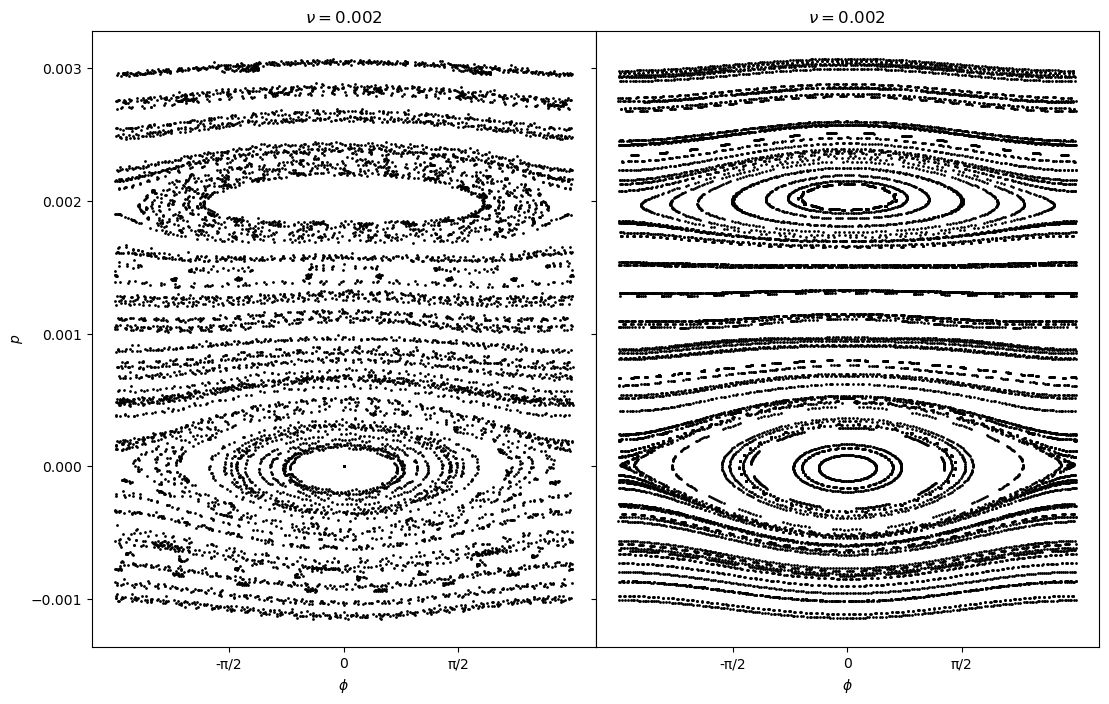

In [9]:
span = 1
# Plot surface of section by rebound and by Hamiltonian
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,8))
f.subplots_adjust(wspace=0)

pomega_0 = np.random.uniform(0,2*np.pi)
    
for lambda_0, P_0 in ic_OE:
    #---------------------------------Nbody-------------------------------------
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    
    lambda1_0, lambda2_0 = np.random.uniform(0,2*np.pi), np.random.uniform(0,2*np.pi)
    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, l=lambda1_0)
    sim.add(m=mu2, P=P2, l=lambda2_0)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, pomega=pomega_0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # track how system developes in time
    sim.t, dt = 0, 1
    dt_epsilon = 0.01
    sign = check(sim,j1,j2,k1,k2)
    N_points, N_points_max = 0, 1000
    phi, p = np.zeros(N_points_max), np.zeros(N_points_max)
    
    while sim.t < 1e4 and N_points < N_points_max:
        oldt, olddt = sim.t, sim.dt
        sim.integrate(oldt+dt)
        nsign = check(sim,j1,j2,k1,k2)
        if sign*nsign < 0 and abs(sign)<0.2:
            leftt = oldt
            rightt = sim.t
            sim.dt = -olddt
            while (rightt-leftt > dt_epsilon):
                # Bisection.
                midt = (leftt+rightt)/2.
                sim.integrate(midt)
                msign = check(sim,j1,j2,k1,k2)
                if msign*sign > 0.:
                    leftt = midt
                    sim.dt = 0.3*olddt
                else:
                    rightt = midt
                    sim.dt = -0.3*olddt
            n_r1 = (j1-k1)/j1*ps[1].n
            Lambda_r1 = sim.G**(2/3)*n_r1**(-1/3)
            Lambda = np.sqrt(sim.G*ps[3].a)
            phi[N_points] = wrapRad(j1*ps[3].l-(j1-k1)*ps[1].l-k1*(ps[3].pomega)+np.pi,span)
            p[N_points] = -np.sqrt(3)*(Lambda-Lambda_r1)/Lambda_r1
            N_points += 1
            sim.dt = olddt
            sim.integrate(oldt+dt)
        sign = nsign
    ax1.scatter(phi,p,[1],color='black')
    
    #-------------------------------------Hamiltonian---------------------------------------------
    phi0 = (j1*lambda_0 - (j1-k1)*lambda1_0 - k1*pomega_0)
    n_r1_0 = (j1-k1)/j1*(2*np.pi/P1)
    Lambda_r1_0 = sim.G**(2/3)*n_r1_0**(-1/3)
    Lambda_0 = np.sqrt(sim.G*(P_0)**(2/3))
    p0 = -np.sqrt(3)*(Lambda_0-Lambda_r1_0)/Lambda_r1_0
    
    num = 200
    t = np.linspace(0,num-1,num)*2*np.pi/(r*nu)
    sol = odeint(hamilton, (phi0,p0), t, args=(epsilon1,epsilon2,r,nu))
    phi = (sol[:,0] + span*np.pi*np.ones(num)) % (2*span*np.pi) - span*np.pi*np.ones(num)
    ax2.scatter(phi, sol[:,1], [1], color='black')
    
ax1.set_ylabel(r'$p$')
ax1.set_xlabel(r'$\phi$')
ax1.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax1.set_title(fr'$\nu={nu}$')

ax2.set_xlabel(r'$\phi$')
ax2.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax2.set_title(fr'$\nu={nu}$')

vary period, momentum,

In [12]:
import sys
import pandas as pd
sys.path.insert(1, '../SPOCKalt')
import plotFunctions
import simsetup


In [28]:
initial = pd.read_csv('../modeldata/originalCondAllData.csv')

sim = simsetup.get_simList(initial.iloc[125054,2:])
simsetup.init_sim_parameters(sim)

/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [23]:
sim.integrate(1e4)

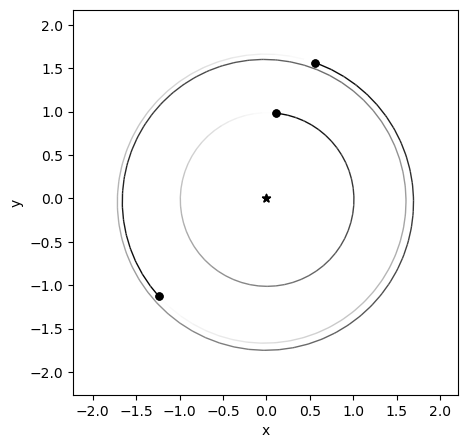

In [24]:
rebound.OrbitPlot(sim)

/home/miniconda3/envs/ethadhani/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 1.0, '$\\nu=0.002$')

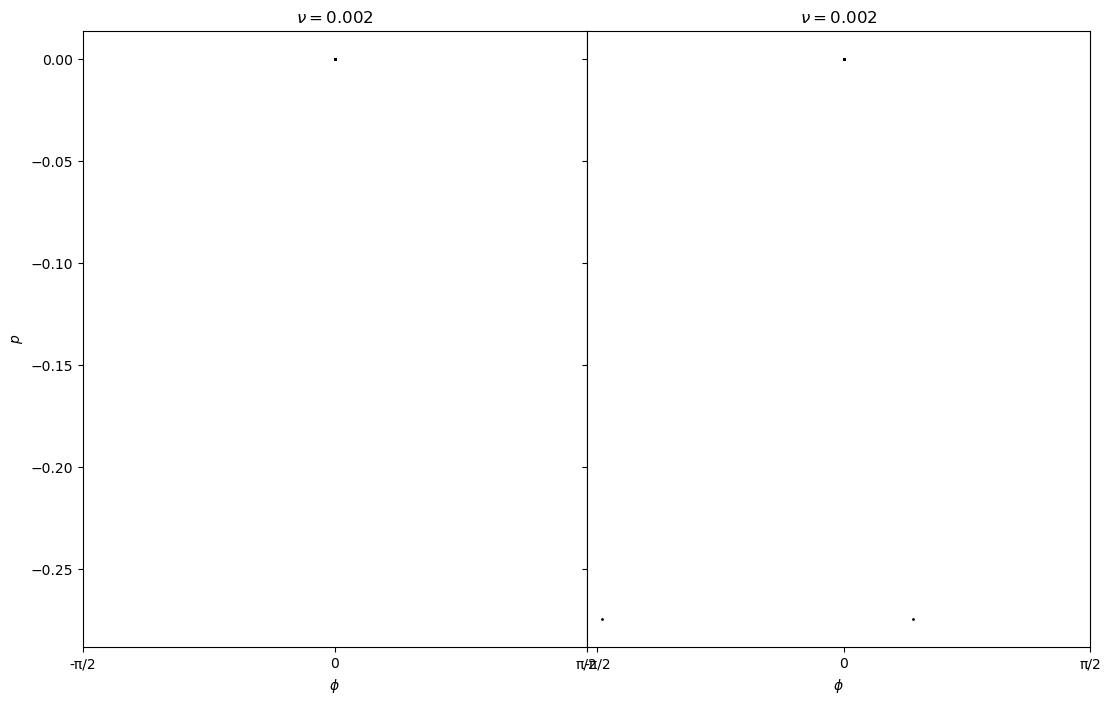

In [32]:
span = 1
# Plot surface of section by rebound and by Hamiltonian
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,8))
f.subplots_adjust(wspace=0)

pomega_0 = np.random.uniform(0,2*np.pi)
    
#for lambda_0, P_0 in ic_OE:
#---------------------------------Nbody-------------------------------------
# start simulation
# sim = rebound.Simulation()
# sim.units = ('yr', 'AU', 'Msun')

# lambda1_0, lambda2_0 = np.random.uniform(0,2*np.pi), np.random.uniform(0,2*np.pi)
# # add star, planet 1, planet 2
# sim.add(m=1.)
# sim.add(m=mu1, P=P1, l=lambda1_0)
# sim.add(m=mu2, P=P2, l=lambda2_0)

# # add test particle
# sim.add(P=P_0, l=lambda_0, e=ecc, pomega=pomega_0)
# sim.move_to_com()
# sim.integrator = "whfast"
# sim.dt = sim.particles[1].P/20
#sim.collision = "direct"
ps = sim.particles
#switch them up
#ps[2],ps[3]=ps[3],ps[2]
ps1=ps[1]
ps2=ps[3]
ps3=ps[2]
lambda1_0, lambda2_0 = ps1.l, ps2.l
# ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
# ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

# track how system developes in time
#sim.t, dt = 0, 1
dt_epsilon = 0.01
sign = check(sim,j1,j2,k1,k2)
N_points, N_points_max = 0, 1000
phi, p = np.zeros(N_points_max), np.zeros(N_points_max)

while sim.t < 1e4 and N_points < N_points_max:
    oldt, olddt = sim.t, sim.dt
    sim.integrate(oldt+dt)
    nsign = check(sim,j1,j2,k1,k2)
    if sign*nsign < 0 and abs(sign)<0.2:
        leftt = oldt
        rightt = sim.t
        sim.dt = -olddt
        while (rightt-leftt > dt_epsilon):
            # Bisection.
            midt = (leftt+rightt)/2.
            sim.integrate(midt)
            msign = check(sim,j1,j2,k1,k2)
            if msign*sign > 0.:
                leftt = midt
                sim.dt = 0.3*olddt
            else:
                rightt = midt
                sim.dt = -0.3*olddt
        n_r1 = (j1-k1)/j1*ps1.n
        Lambda_r1 = sim.G**(2/3)*n_r1**(-1/3)
        Lambda = np.sqrt(sim.G*ps3.a)
        phi[N_points] = wrapRad(j1*ps3.l-(j1-k1)*ps1.l-k1*(ps3.pomega)+np.pi,span)
        p[N_points] = -np.sqrt(3)*(Lambda-Lambda_r1)/Lambda_r1
        N_points += 1
        sim.dt = olddt
        sim.integrate(oldt+dt)
    sign = nsign
ax1.scatter(phi,p,[1],color='black')

#-------------------------------------Hamiltonian---------------------------------------------
phi0 = (j1*lambda_0 - (j1-k1)*lambda1_0 - k1*pomega_0)
n_r1_0 = (j1-k1)/j1*(2*np.pi/P1)
Lambda_r1_0 = sim.G**(2/3)*n_r1_0**(-1/3)
Lambda_0 = np.sqrt(sim.G*(P_0)**(2/3))
p0 = -np.sqrt(3)*(Lambda_0-Lambda_r1_0)/Lambda_r1_0

num = 200
t = np.linspace(0,num-1,num)*2*np.pi/(r*nu)
sol = odeint(hamilton, (phi0,p0), t, args=(epsilon1,epsilon2,r,nu))
phi = (sol[:,0] + span*np.pi*np.ones(num)) % (2*span*np.pi) - span*np.pi*np.ones(num)
ax2.scatter(phi, sol[:,1], [1], color='black')

ax1.set_ylabel(r'$p$')
ax1.set_xlabel(r'$\phi$')
ax1.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax1.set_title(fr'$\nu={nu}$')

ax2.set_xlabel(r'$\phi$')
ax2.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax2.set_title(fr'$\nu={nu}$')